Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Lastly, hit **Validate**.

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = ""
COLLABORATORS = ""

---

# Lab 3: Data Cleaning and Visualization

## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## Due Date

** This assignment is due Tuesday 6th Feb at 1:00AM **


In this lab, you will be working on the Berkeley Police Department - Calls Data https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5

To avoid the issues met in `hw2.ipynb`, you will not be working directly on data from this URL, but on a snapshot of the data, to make sure that we all work with the same data files.

The data contains some interesting information but you may need to clean it a bit first.

You may find the material in the lecture helpful.

## Setup

Note that after activating matplotlib to display figures inline via the IPython magic `%matplotlib inline`, we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

## Question 0
### Question 0a
We will reuse the `fetch_and_cache` utility.
Import it from your `utils.py` (which should be in the `lab02` folder) or redefine it below.

In [4]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir = "data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results
    data_dir:(default="data") the location to save the data
    force: if true the file is always re-downloaded
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir/Path(file)
    
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time
        time_downloaded = time.ctime(file_path.stat().st_ctime)
        print("Using version already downloaded:", time_downloaded)
    return file_path

In [5]:
# This checks whether you imported/defined fetch_and_cache
import types
assert type(fetch_and_cache) == types.FunctionType

In [6]:
data_url = 'http://www.ds100.org/sp18/assets/datasets/lab03_data.zip'
file_name = 'lab03_data.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Sat Jul 21 19:20:21 2018
Located at data/lab03_data.zip


We will now directly unzip the ZIP archive and start working with the uncompressed files.

There is no single right answer to whether to work with compressed files in their compressed state or whether to uncompress them on disk permanently. If you e.g. need to work with multiple tools on the same files, or write many notebooks to analyze them, and they are not too large, it may be more convenient to uncompress them once.  But you may also have situations where you find it preferable to work with the compressed data directly.  
Python gives you tools for both approaches, and you should know how to perform both tasks in order to choose the one that best suits the problem at hand.

---

Here, the ZIP archive contains a `data` folder with a few files in it. Contrary to `hw2.ipynb`, it is the archive of a **folder**, not of a file.

Therefore, we will not specify a destination folder to `extractall`, but directly extract the `data` folder in the zip archive in the current working directory, denoted by `.` in the cell below.

In [7]:
my_zip = zipfile.ZipFile(dest_path, 'r')
# Note the '.' argument
my_zip.extractall('.')

### Question 0b
Let us use a pathlib functionality to list all files in the `data` directory. You may find useful information in pathlib [docs](https://docs.python.org/3/library/pathlib.html).


Use pathlib's `glob` method to store in the variable `file_names` the list of all files' names in the `data_dir` directory.

Use pathlib's `glob` method to store in the variable `python_files` the sublist of all python files' names in the `data_dir` directory.

In [8]:
data_dir = Path('data')
file_names = [str(i) for i in list(data_dir.glob('**/*'))]
python_files = [str(i) for i in list(data_dir.glob('**/*.py'))]


print(file_names)
print(python_files)

['data/dummy.txt', 'data/do_not_readme.md', 'data/go_bears.py', 'data/Berkeley_PD_-_Calls_for_Service.csv', 'data/hello_world.py', 'data/lab03_data.zip']
['data/go_bears.py', 'data/hello_world.py']


In [9]:
assert isinstance(file_names, list)
assert all([isinstance(file, str) for file in file_names])


Let us load in a `pandas.DataFrame` objet the CSV file we have.

In [10]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA


First let's check basic info. The following methods are very useful.

In [11]:
calls.info()
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 11 columns):
CASENO            5508 non-null int64
OFFENSE           5508 non-null object
EVENTDT           5508 non-null object
EVENTTM           5508 non-null object
CVLEGEND          5508 non-null object
CVDOW             5508 non-null int64
InDbDate          5508 non-null object
Block_Location    5508 non-null object
BLKADDR           5481 non-null object
City              5508 non-null object
State             5508 non-null object
dtypes: int64(2), object(9)
memory usage: 473.4+ KB


,CASENO,CVDOW
count,5.508000e+03,5508.000000
mean,1.704372e+07,3.076616
std,2.633874e+04,1.997259
min,1.700023e+07,0.000000
25%,1.702357e+07,1.000000
50%,1.703655e+07,3.000000
75%,1.704843e+07,5.000000
max,1.709167e+07,6.000000


Then we can go over the fields to see what are their meanings. We can first check if all events happened in Berkeley.

In [12]:
calls.groupby(["City","State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
City,State,,,,,,,,,
Berkeley,CA,5508,5508,5508,5508,5508,5508,5508,5508,5481


### Question 1
It seems OFFENSE and CVLEGEND are both about the type of event. What is the difference between the two? Try to use the `groupby` method to group the two keys.

You should be able to see that CVLEGEND is a broader category of crime. For example, there are three sub-categories in OFFENSE that correspond to LARCENY in CVLEGEND. Find them and save the results in `answer1` (should be a list of strings, you may manually type in the answer).

In [13]:
# You may use this cell for your scratch work as long as you enter
# in your final answers in the answer1 variable.
answer1 = calls[calls.CVLEGEND == "LARCENY"]["OFFENSE"].values
answer1 = list(np.unique(answer1))

In [14]:
assert isinstance(answer1, list)
assert all([isinstance(elt, str) for elt in answer1])
assert len(answer1) == 3
# This makes sure all the values you gave are indeed values of calls['OFFENSE'] (no typo)
assert all([elt in calls['OFFENSE'].values for elt in answer1])



### Question 2

#### Question 2a

What are the five crime types of CVLEGEND that have the most crime events? You may need to use `value_counts` to find the answer.
Save your results into `answer2a` as a list of strings

In [15]:
answer2a = list(calls["CVLEGEND"].value_counts(ascending = False).index[:4])
answer2a

['LARCENY', 'BURGLARY - VEHICLE', 'VANDALISM', 'DISORDERLY CONDUCT']

In [16]:
assert isinstance(answer2a, list)
assert all([isinstance(elt, str) for elt in answer2a])
# This makes sure all the values you gave are indeed values of the DataFrame (no typo)
assert all([elt in calls['CVLEGEND'].values for elt in answer2a])


### Pandas Plotting

Pandas offers basic functionality for plotting.  Take a look at the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html).

In this lab we will use a few of the basic functions.

#### Question 2b

In the following example we use the `barh` plot type to visually display the value counts for `CVLEGEND`.

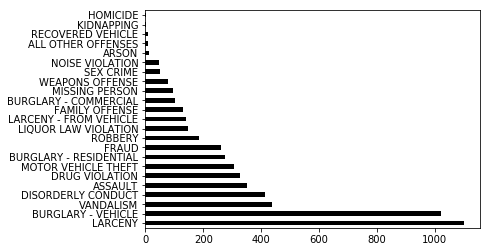

In [17]:
calls['CVLEGEND'].value_counts().plot(kind='barh', colormap='cubehelix');

Look at the documentation and try to construct a regular bar plot in which the bars are oriented vertically.

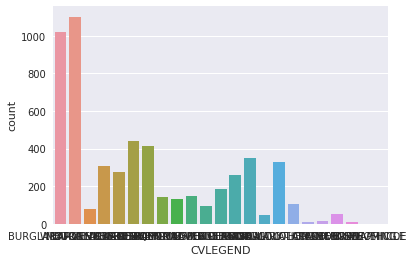

In [18]:
sns.set()
sns.countplot(x = "CVLEGEND" , data=calls)

# Leave this for grading purposes
ax_2b = plt.gca()

In [19]:
import matplotlib 
# Check ordering
bars = [rect.get_height() for rect in ax_2b.patches 
        if isinstance(rect, matplotlib.patches.Rectangle) and rect.get_x() != 0.0
       ]
# Check values
assert set(bars) == set(calls['CVLEGEND'].value_counts().data)

/home/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys


### Question 3a

The CVDOW field isn't named helpfully and it is hard to see the meaning from the data alone. According to the website, CVDOW is actually indicating the day that events happend. 0->Sunday, 1->Monday ... 6->Saturday. 

Add a new column `Day` into the `calls` dataframe that has the string weekday (eg. 'Sunday') for the corresponding value in CVDOW.

**Hint:** *Try evaluating `days[calls["CVDOW"]]`.  Can you assign this to the new column `calls["Day"]`?*

In [20]:
days = np.array(["Sunday", "Monday", "Tuesday", 
                 "Wednesday", "Thursday", "Friday",
                 "Saturday"])
calls["Day"] = days[calls["CVDOW"]]
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...",2500 LE CONTE AVE,Berkeley,CA,Sunday
1,17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,Thursday
2,17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...",200 UNIVERSITY AVE,Berkeley,CA,Thursday
3,17019145,GUN/WEAPON,04/06/2017 12:00:00 AM,17:30,WEAPONS OFFENSE,4,08/29/2017 08:27:59 AM,"1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...",1900 SEVENTH ST,Berkeley,CA,Thursday
4,17044993,VEHICLE STOLEN,08/01/2017 12:00:00 AM,18:00,MOTOR VEHICLE THEFT,2,08/29/2017 08:28:05 AM,"100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...",100 PARKSIDE DR,Berkeley,CA,Tuesday
5,17037319,BURGLARY RESIDENTIAL,06/28/2017 12:00:00 AM,12:00,BURGLARY - RESIDENTIAL,3,08/29/2017 08:28:03 AM,"1500 PRINCE ST\nBerkeley, CA\n(37.851503, -122...",1500 PRINCE ST,Berkeley,CA,Wednesday
6,17030791,BURGLARY RESIDENTIAL,05/30/2017 12:00:00 AM,08:45,BURGLARY - RESIDENTIAL,2,08/29/2017 08:28:00 AM,"300 MENLO PL\nBerkeley, CA\n",300 MENLO PL,Berkeley,CA,Tuesday
7,17091066,BURGLARY AUTO,05/29/2017 12:00:00 AM,17:00,BURGLARY - VEHICLE,1,08/29/2017 08:28:01 AM,"2317 SHATTUCK AVE\nBerkeley, CA\n(37.867326, -...",2317 SHATTUCK AVE,Berkeley,CA,Monday
8,17031395,VANDALISM,06/01/2017 12:00:00 AM,20:00,VANDALISM,4,08/29/2017 08:28:00 AM,"ACTON STREET &amp; PARKER ST\nBerkeley, CA\n(3...",ACTON STREET & PARKER ST,Berkeley,CA,Thursday
9,17041467,DISTURBANCE,07/17/2017 12:00:00 AM,01:30,DISORDERLY CONDUCT,1,08/29/2017 08:28:04 AM,"2100 SEVENTH ST\nBerkeley, CA\n(37.866936, -12...",2100 SEVENTH ST,Berkeley,CA,Monday


In [137]:
assert set(calls["Day"]) == {'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}
assert calls["Day"][0] == 'Sunday'


### Question 3b


Construct a vertical bar plot with the count of the number of entries in the table for each day of the week **ordered by the day of the week** (eg. `Sunday`, `Monday`, ...). 

**Hint:** *Try evaluating `value_counts()[days]` to order the days.*


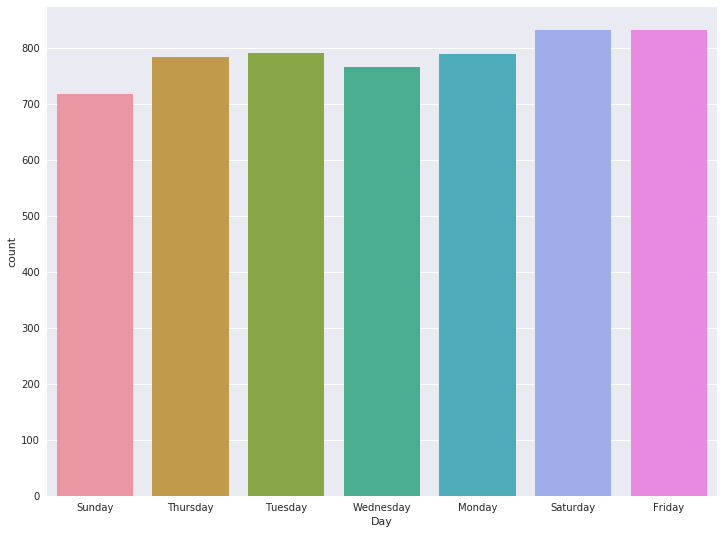

In [139]:
sns.set()
sns.countplot("Day", data = calls)

# Leave this for grading purposes
ax_3b = plt.gca()

In [140]:
import matplotlib 
# Check ordering
assert np.alltrue(np.array([l.get_text() for l in ax_3b.xaxis.get_ticklabels()]) == days)
bars = [rect.get_height() for rect in ax_3b.get_children() 
        if isinstance(rect, matplotlib.patches.Rectangle) and rect.get_x() != 0.0
       ]
# Check values
assert np.alltrue(np.array(bars) == calls['Day'].value_counts()[days].data)

AssertionError: 

It seems Saturday and Friday have slightly more crimes than the others, while Sunday is the lowest. But the difference does not look significant.  
We can break down into some particular types of events to see their distribution. For example, please make a `countplot` for the "NOISE VIOLATION". Which two days are the peak for "NOISE VIOLATION"?  
Put your results into `answer3b` as a list of strings, manually if you prefer.

In [149]:
Noise_violation = calls[calls.CVLEGEND == "NOISE VIOLATION"]

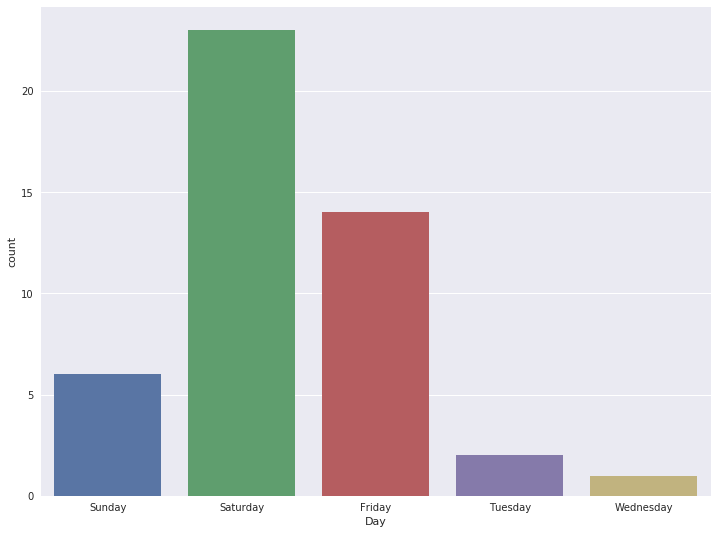

In [150]:
sns.set()
sns.countplot("Day", data= Noise_violation)

In [151]:

answer3b = ["Tuesday", "Wednesday"]

In [153]:
assert isinstance(answer3b, list)
assert all([isinstance(elt, str) for elt in answer3b])
assert all([elt in calls['Day'].values for elt in answer3b])


### Question 4a
Now let's look at the EVENTTM column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` dataframe. You should save the hour as an `int`. Then plot the frequency of each hour in the table (i.e., `value_counts()`) sorted by the hour of the day (i.e., `sort_index()`).

You will want to look into how to use:

* [Series.str.slice](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.slice.html#pandas.Series.str.slice) to select the substring.
* [Series.astype](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html) to change the type.

**Hint:** *The `str` helper member of a series can be used to grab substrings.  For example, `calls["EVENTTM"].str.slice(3,5)` returns the minute of each hour of the `EVENTTM`.*

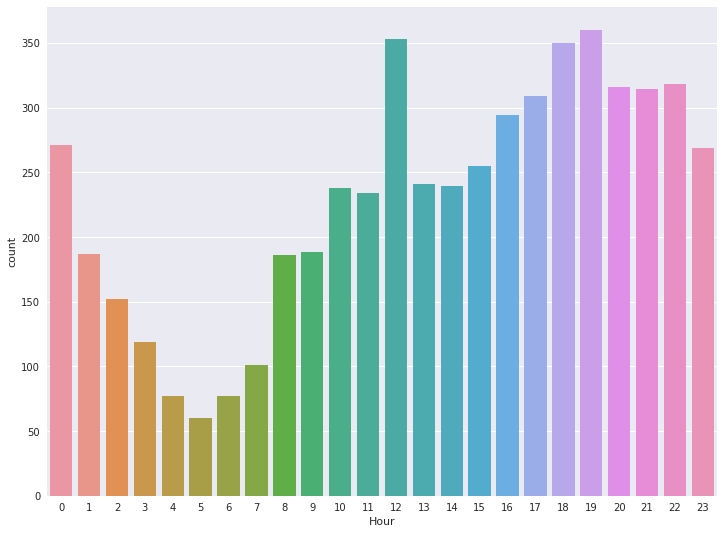

In [161]:
calls["Hour"] = calls["EVENTTM"].str.slice(0, 2).astype(int)
sns.set()
sns.countplot(x = "Hour",  data = calls)

In [162]:
assert 'Hour' in calls.columns
assert set(calls["Hour"]) == set(range(24))


### Question 4b

Now let's construct a boxplot which examines the hour of day of each crime broken down by the `CVLEGEND` value.  To construct this plot you will want to read the [DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html) documentation.

Which crime type appears to have the largest interquartile range? Put your results into `answer4b` as a string.

**Hint:** *To construct the box plot you will need to specify the `column` to summarize (e.g., `"Hour"`) as well as the criterion to group `by` (e.g., `"CVLEGEND"`).*

**Hint:** *To rotate the labels so they are readable you migth want to set `rot` to `90`.*

**Hint:** *To make the plot more readable you might want to set `figsize=(10,8)`.*

In [166]:
calls.groupby("CVLEGEND")

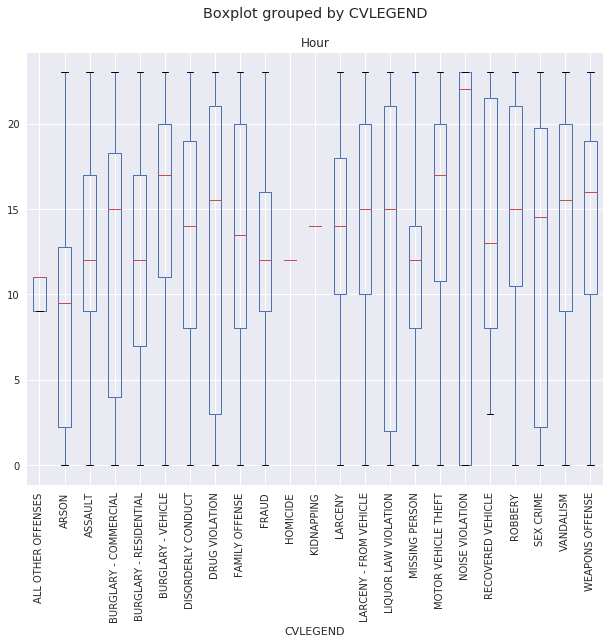

In [171]:
calls.boxplot(column = "Hour", by = "CVLEGEND", rot=90, figsize=(10, 8))

In [172]:
answer4b = "NOISE VIOLATION"

In [173]:
assert isinstance(answer4b, str)

## Congratulations

Congrats! You are finished with this assignment.